- 이 글에서는 쿼럼을 사용하는 이점과 장애 시에 꼭 필요한 최소 쿼럼 수에 대한 이야기를 설명

**Amazon Aurora 스토리지**

-  고성능 관계형 데이터베이스의 강력한 성능, 가용성 및 내구성 요구 사항을 충족시키는 고도의 분산 시스템

- Aurora 스토리지를 위해 쿼럼을 사용하기로 결정한 이유와 3개의 가용 영역(AZ)에 6개의 데이터 복사본을 배포하는 이유에 대해 설명.

- 실제 데이터베이스 운영 환경에서 내구성, 가용성 및 성능 간의 트레이드오프(Trade-off)에 대해 논의하는 공개적으로 이용 가능한 자료가 많지 않다.

- 데이터베이스 트랜잭션을 설계할 때 고려해야 할 사항을 기반으로 하고 있지만, 가변적인 분산 상태의 조정에 관계된 시스템을 설계하는 사람들이라면 모두 이해하면 좋을 것.

**분산 스토리지가 좋은 아이디어이지만, 잘 구현하기 어려운 이유**

<br>

**분산 스토리지를 사용하는 것이 좋은 이유**

- 단일 시스템에 데이터베이스 소프트웨어와 스토리지를 함께 배치하여 빠르게 실행되게 하는 것은 쉬운 일.
 - 문제는 시스템에 장애가 발생한다는 것.
 - 장애 발생 후에 백업에서 복구하는 데는 시간이 걸릴 뿐 아니라 많은 시스템들이 백업 되지 않은 데이터를 잃어 버릴 수 밖에 없다.

- 데이터베이스 인스턴스에서 스토리지를 분리하면 유연성이 향상.
  - 사용자는 데이터베이스를 종료하거나, 데이터베이스의 크기를 늘이거나 줄이고, 읽기 전용 복제본을 추가하고 제거하는 등 다양한 작업을 함.
  - 스토리지를 데이터베이스에서 분리하면 기반 스토리지를 새로운 곳에서 다시 생성하지 않고 기존의 스토리지를 분리하고 다시 연결할 수 있기 때문에 이러한 작업을 쉽게 수행 할 수 있다.

- 데이터는 컴퓨팅과 다르게 쉽게 움직이기 어려운 관성(Gravity)이 있다.
  - 컴퓨팅에서 스토리지를 분리하면 독립적으로 장애가 발생할 수 있는 더 많은 장치가 생기며, 이 때문에 동기식 또는 비동기식의 복제를 사용하게 됨.
  - 장애가 독립적인 경우 복제를 통해 내구성을 향상.

**데이터 복제 역시 몇 가지 문제**
- 동기식 복제에서는 하나의 쓰기가 내구성을 갖추려면, 모든 복사본을 확인해야 함.
  - 이 방법에서 속도는 디스크, 노드 또는 네트워크 경로에 중 가장 느린 요소에서 얼마나 느린가에 의해 결정.

- 비동기식 복제는 지연 시간을 낮출 수 있지만 데이터를 복제하고 데이터 내구성을 확인하기 전에 장애가 발생하면 데이터가 손실될 수 있다.

- 두 방식 모두 완벽하지 않다.
  - 장애가 발생하면 복제 구성원 집합에 변경이 발생하게 되므로 쉽지 않다.
  - 삭제 된 복제본을 다시 생성하는 것은 비용이 많이 발생하기 때문에 일반적으로 사용자들은 그렇게 하지 않으려고 함.
  - 이렇게 되면 복제본이 구성되기 전까지 몇 분간 이용을 할 수 없게 됨.



**쿼럼(Quorum) 모델**

- Aurora는 대신 쿼럼 모델을 사용.
- 쿼럼 모델에서는 데이터 복사본의 일부를 읽고 쓰게 됨.


- 공식적으로 V 복사본을 사용하는 쿼럼 시스템은 두 가지 규칙을 따라야 함.
  - 읽기 세트 Vr과 쓰기 세트 Vw가 최소 하나의 중첩된 복사본을 가져야 함.
    - 즉, 세 개의 데이터 복사본이 있는 경우, 읽기 세트와 쓰기 세트가 중첩된 복사본을 갖기 위해 각각 2개로 이뤄짐.
    - 이 규칙으로 인해 데이터 항목을 두 개의 트랜잭션에 의해 동시에 읽고 쓰여지지 않도록 합니다.
    - 읽기 쿼럼에 데이터 항목의 최신 버전이 있는 하나 이상의 사이트가 포함되도록 합니다.

  - 쓰기에 사용된 쿼럼이 이전의 쓰기 쿼럼과 중첩되도록 해야 함.
    - 이 작업은 Vw> V / 2를 보장함으로써 쉽게 수행할 수 있습니다.
    - 이 규칙은 두 트랜잭션의 두 개의 쓰기 조작이 동일한 데이터 항목에서 동시에 발생할 수 없도록 합니다.


**가능한 몇 가지 쿼럼 모델**

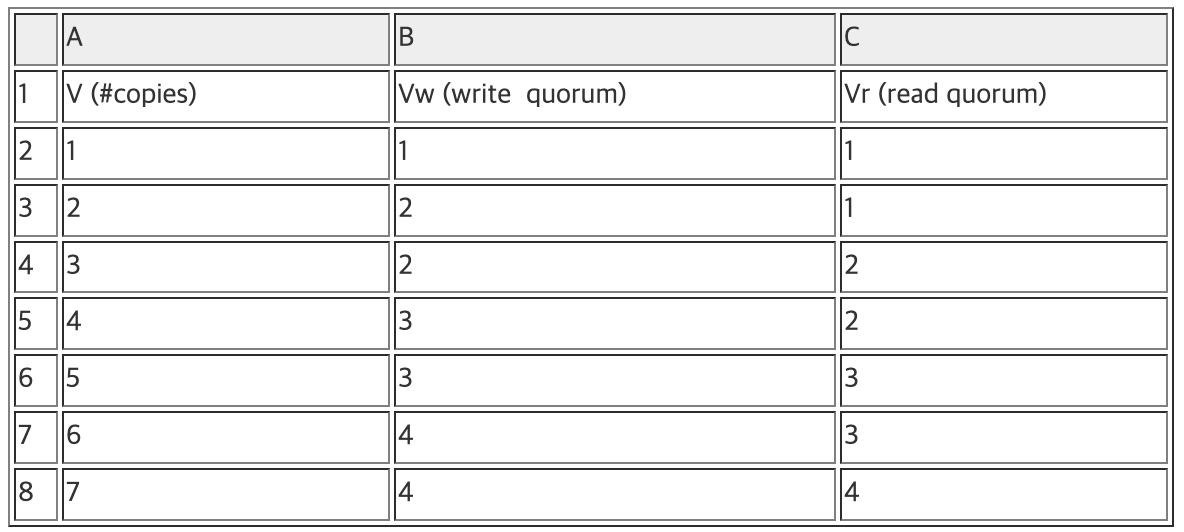

- 쿼럼 시스템은 몇 가지 장점을 가지고 있다.
- 장시간 노드에 오류가 있더라도 (재부팅 같은) 일시적인 오류 또는 구성 요소 중 하나가 느린 경우를 해결하는 것과 같은 방식으로 처리할 수 있다.

**Amazon Aurora 쿼럼**

- Amazon Aurora에서는 3 개의 가용 영역(AZ)에 걸쳐 4개의 쓰기 세트와 3 개의 읽기 세트가 있는 6개 복사본 쿼럼을 사용.

  - Aurora는 여섯 개의 복사본에 쓰기를 수행하여 네 개의 복사본에서 쓰기 완료 응답을 받으면 해당 쓰기가 완료된 것으로 확인.
  - 노드 중 하나가 느리게 실행되는 경우도 상관 없음.
  - 다른 노드들이 신속하게 응답하고 있고, 느린 노드도 바로 따라 잡음.
  - 만약 노드 중 하나를 잠깐 사용할 수 없더라도 쓰기 또는 읽기 가용성이 떨어지지 않으며, 노드가 다시 복구되면 요청을 계속 받아들임.
  - 노드가 영구적으로 중단 된 경우, Aurora는 노드가 일정 시간동안 응답하지 않으면 멤버십 변경 프로토콜을 사용하여 새 구성원을 쿼럼 세트에 추가.

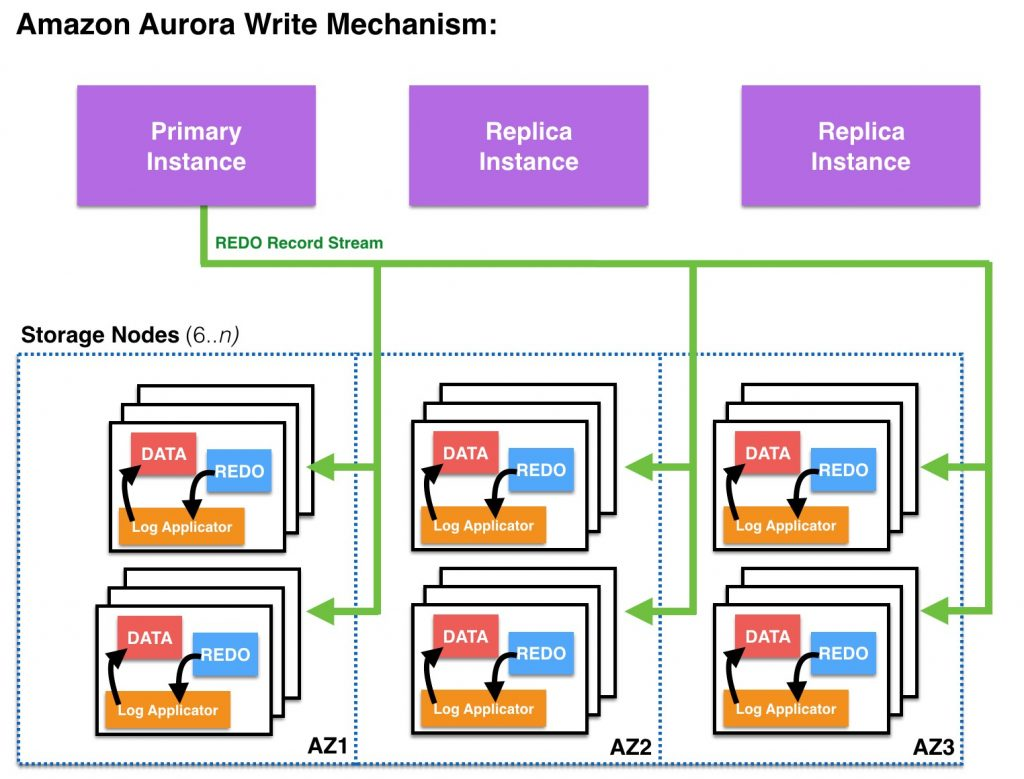


- 6개 복사본을 사용하는 이유는 앞서 이야기한 2/3 쿼럼 세트에서도 마찬가지로 적용되며, 다수 운영 환경의 분산 시스템에서 일반적으로 사용하기 때문.
  - 이러한 시스템은 하나의 오류를 투명하게 처리할 수 있으며, 오류를 수정하는 동안 독립적인 추가 결함이 발생할 가능성은 매우 낮다.

- 2/3 쿼럼에서 생길 수 있는 문제는 모든 오류가 독립적인 것은 아니라는 것.

- 2/3 쿼럼에서 하나의 복사본을 각각의 세 개의 AZ에 가지고 있다고 가정.
  -  AWS 클라우드와 같은 대규모 분산 시스템에서는 노드, 디스크 및 네트워크 경로 장애 등에 대한 낮은 수준의 백그라운드 노이즈가 지속적으로 발생.
  -  2/3 쿼럼은 이러한 실패를 투명하게 허용하기 때문에 일어나더라도 큰 문제는 없다.
  - 두 개의 오류가 동시에 발생할 확률이 극히 낮을 정도로 백그라운드 노이즈의 영향은 작다.

- AWS 리전을 AZ로 분리하는 이유는 오류에 대한 격리 영역을 만들기 위해서입니다.

- 특정 AWS 지역의 3개 AZ 중 하나가 다운되었다고 가정.
  - 지붕 붕괴, 화재, 홍수, 토네이도 또는 이와 유사한 이유로 영구적으로 다운되거나, 정전이나 소프트웨어 설치 불량 등으로 인해 단기간 동안 다운될 수도 있다.
  - 이러한 이슈가 생기면 동시에 모든 쿼럼에서 한 벌의 복사본을 잃게 됨.
  - 이미 오류를 처리하고 있던 소수의 쿼럼에서는 이제 이중 오류가 있다.
  -  이 시점에서 1/3 복사본만 읽을 수 있으며, 이들 복사본이 모든 쓰기를 반영했다는 것을 보장할 수 없습니다.
  - 복사본은 다른 두 개의 복사본이 쓰일 때 쓰기 응답을 주지 않은(쓰기를 반영하지 않은) 복사본일 수 있다.
  - 따라서, 이 경우 쿼럼은 쓰기, 읽기 또는 복구가 불가능하며 데이터베이스 볼륨이 손실됨.

- 6개 복사본 쿼럼 모델은 한 AZ의 전체 손실에도 쓰기 가용성을 잃지 않고 내결함성을 유지할 수 있으며 한 AZ의 손실 및 하나의 추가 오류에도 데이터 손실이 없게 유지.
- 유효한 읽기 쿼럼을 가지고 있는 한, 데이터의 추가 사본을 다시 만들어 전체 복구된 쿼럼을 확보.
- “AZ + 1” 결함 모델에서는 최소 3개의 AZ와 각 AZ에 적어도 2개의 사본이 필요하다는 것을 쉽게 알 수 있다.
- 3/4 쿼럼 또는 3/5 쿼럼을 실행하면서도 “AZ + 1″목표를 계속 충족시킬 수 있지만, 이 때는 리전에 4 ~ 5 개의 독립 AZ가 있는 환경에서만 가능.

**여섯 개의 복사본으로 충분합니까?**

- '**여섯 개의 복사본이 필요하지만 이것으로 충분한가**'에 대해서는 평균 고장 시간(MTTF)과 평균 수리 시간(MTTR)을 고려해야함 .
- 볼륨을 복구하는 능력을 상실하는 것은 읽기 가용성을 잃는 것을 의미.
- 6개 복사본 쿼럼 모델에서 읽기 가용성을 잃는 것은 4개의 독립적인 오류, 2개의 독립적인 오류 및 하나의 AZ 오류 또는 2개의 독립적인 AZ 오류 등으로 6 개의 데이터 사본 중 4개를 잃는 것을 의미.
- 이들 중 가장 가능성이 있는 것은 오류가 발생한 노드가 있고, 전체 AZ 오류가 발생한 다음 다른 노드가 첫 번째 오류가 발생한 노드를 복구하는 중 다운되는 것.

<br>

- 가능성은 낮지만 MTTF와 MTTR이 충분하지 않을 경우도 발생할 수 있다.
- 특정 시점부터는 MTTF와 독립적인 오류 가능성을 개선하기가 어렵기 때문에, MTTR을 줄이는 것이 가장 좋은 방안.

<br>

- Aurora에서는 데이터베이스 볼륨을 10GB 청크(Chunk) 단위로 분할하고 각각 6개의 복사본을 사용하여 보호 그룹에 독립적으로 복제하는 방식으로 이를 구현.
  - 대규모 데이터베이스 볼륨은 수천 개의 노드에 분포되어 있을 수 있다.
  - 10 기가비트(Gbit) 네트워크 환경에서 10GB 단위의 쿼럼을 복구하는 데는 1분 미만의 시간이 걸린다.
  - 감지 시간과 일시적인 이슈를 복구하는 것을 피하기 위한 히스테리시스를 고려해도 MTTR은 몇 분 밖에 걸리지 않는다.
  - 다른 장애들은 이 장애와 별개이므로, 이 시간 안에 3개의 독립적인 추가 이슈 또는 AZ 문제 및 1개의 추가 문제가 발생할 가능성은 매우 낮다.
  - 오히려 스토리지 계층에 대한 소프트웨어 배포는 간단.
  - 단순히 노드를 중지하고 소프트웨어를 설치 한 다음 다시 시작함으로써 시스템이 장애를 훨씬 더 많이 투명하게 처리할 수 있다.

- 이 접근법은 데이터 집중 현상(heat) 관리에도 도움.
  - 핫 디스크 또는 핫 노드의 세그먼트를 죽은 것으로 간단하게 표시 할 수 있으며 스토리지 플릿의 다른 노드로 자동 복구.
  - 만약 화재나 홍수로 몇 달 동안 특정 AZ를 가동할 수 없게 되어 재구축해야 하는 경우는?
  - 이 경우 6개의 복사본 중 2개를 잃어버린 것이며, 추가로 이중 오류나 AZ 손실로 인해 데이터베이스 볼륨이 손실 될 수 있다.
  - Aurora에서는 실제로 재해 수준의 이슈 이후에 AZ를 재건할 때까지 빠른 수리시간(MTTR)에 대해서도 고려하고 있다.

- Aurora는 최근에 이러한 경우를 대응하기 위한 저하 모드(degraded mode)를 도입하는 소프트웨어를 배포.
  -  이 모드에서 Aurora는 AZ의 장기 손실 기간 동안 3/4 쓰기 쿼럼과 2/4 읽기 쿼럼으로 동작할 수 있다.
  - 그런 다음, AZ를 다시 사용할 수 있게 되면 전체 6개 복사본 3-AZ 쿼럼으로 복구할 수 있다.
  - 이 방법을 사용하면 나머지 AZ 중 하나의 일시적인 손실을 복구할 수 있고, 쓰기 가용성을 유지하면서 추가로 하나의 장애를 허용할 수 있다.